In [ ]:
!pip install -q -U google-generativeai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 1.2 MB/s eta 0:00:00


In [ ]:
import pathlib
import textwrap

import google.generativeai as genai

from IPython.display import display
from IPython.display import Markdown


def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

In [ ]:
# Used to securely store your API key
from google.colab import userdata

In [ ]:
# Or use `os.getenv('GOOGLE_API_KEY')` to fetch an environment variable.
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

genai.configure(api_key=GOOGLE_API_KEY)

In [ ]:
for m in genai.list_models():
  if 'generateContent' in m.supported_generation_methods:
    print(m.name)

models/gemini-1.0-pro
models/gemini-1.0-pro-001
models/gemini-1.0-pro-latest
models/gemini-1.0-pro-vision-latest
models/gemini-1.5-flash
models/gemini-1.5-flash-001
models/gemini-1.5-flash-latest
models/gemini-1.5-pro
models/gemini-1.5-pro-001
models/gemini-1.5-pro-latest
models/gemini-pro
models/gemini-pro-vision


## Generate text from text inputs

For text-only prompts, use the `gemini-pro` model:

In [ ]:
model = genai.GenerativeModel('gemini-1.5-flash')

The `generate_content` method can handle a wide variety of use cases, including multi-turn chat and multimodal input, depending on what the underlying model supports. The available models only support text and images as input, and text as output.

In the simplest case, you can pass a prompt string to the <a href="https://ai.google.dev/api/python/google/generativeai/GenerativeModel#generate_content"><code>GenerativeModel.generate_content</code></a> method:

In [ ]:
%%time
response = model.generate_content("What do you make of India losing 2023 odi wc finals")

CPU times: user 70.3 ms, sys: 7.23 ms, total: 77.5 ms
Wall time: 5.02 s


In simple cases, the `response.text` accessor is all you need. To display formatted Markdown text, use the `to_markdown` function:

In [ ]:
to_markdown(response.text)

> India's loss in the 2023 ODI World Cup final was a disappointment for many fans and players alike. It's natural to feel sad and frustrated when a team you support doesn't achieve victory. Here's a balanced perspective:
> 
> **Factors Contributing to the Loss:**
> 
> * **Australia's Strong Performance:** Australia played exceptional cricket throughout the tournament, showcasing great batting, bowling, and fielding. They were the deserved winners.
> * **India's Inconsistency:** While India showed moments of brilliance, they struggled with consistency throughout the tournament. This was particularly evident in the final where they failed to put up a competitive score.
> * **Pressure and Expectations:** India entered the tournament as a strong contender, leading to immense pressure and expectations. This could have impacted the team's performance.
> 
> **Moving Forward:**
> 
> * **Learn from the Experience:**  The loss provides valuable lessons for the team, highlighting areas where they need to improve.
> * **Maintain Focus and Determination:** India has a strong squad with potential. The key is to stay focused on their goals and continue working hard.
> * **Building for the Future:**  The loss shouldn't be seen as a setback but an opportunity to learn and grow.  India can use this experience to build a stronger team for future tournaments.
> 
> **Overall:**
> 
> While India's loss in the final was disappointing, it's important to remember that cricket is a game of skill, strategy, and a bit of luck.  There are many factors that can contribute to the outcome of a match, and sometimes, despite their best efforts, teams don't succeed. The key is to learn from the experience and come back stronger. 


If the API failed to return a result, use `GenerateContentResponse.prompt_feedback` to see if it was blocked due to safety concerns regarding the prompt.

In [ ]:
response.prompt_feedback

Gemini can generate multiple possible responses for a single prompt. These possible responses are called `candidates`, and you can review them to select the most suitable one as the response.

View the response candidates with <a href="https://ai.google.dev/api/python/google/generativeai/protos/GenerateContentResponse#candidates"><code>GenerateContentResponse.candidates</code></a>:

In [ ]:
response.candidates

[content {
  parts {
    text: "India\'s loss in the 2023 ODI World Cup final was a disappointment for many fans and players alike. It\'s natural to feel sad and frustrated when a team you support doesn\'t achieve victory. Here\'s a balanced perspective:\n\n**Factors Contributing to the Loss:**\n\n* **Australia\'s Strong Performance:** Australia played exceptional cricket throughout the tournament, showcasing great batting, bowling, and fielding. They were the deserved winners.\n* **India\'s Inconsistency:** While India showed moments of brilliance, they struggled with consistency throughout the tournament. This was particularly evident in the final where they failed to put up a competitive score.\n* **Pressure and Expectations:** India entered the tournament as a strong contender, leading to immense pressure and expectations. This could have impacted the team\'s performance.\n\n**Moving Forward:**\n\n* **Learn from the Experience:**  The loss provides valuable lessons for the team, hi

By default, the model returns a response after completing the entire generation process. You can also stream the response as it is being generated, and the model will return chunks of the response as soon as they are generated.

To stream responses, use <a href="https://ai.google.dev/api/python/google/generativeai/GenerativeModel#generate_content"><code>GenerativeModel.generate_content(..., stream=True)</code></a>.

In [ ]:
%%time
response = model.generate_content("What do you make of India losing 2023 odi wc finals", stream=True)

CPU times: user 82.2 ms, sys: 6.74 ms, total: 89 ms
Wall time: 5.98 s


In [ ]:
for chunk in response:
  print(chunk.text)
  print("_"*80)

India
________________________________________________________________________________
's loss in the 2023 ODI World Cup final was a
________________________________________________________________________________
 disappointing result for Indian fans, but it's important to remember that it was
________________________________________________________________________________
 a close game against a strong Australian team. Here are some perspectives on the loss:

**Positives:**

* **Strong Performance Throughout the Tournament:** India played
________________________________________________________________________________
 well throughout the tournament, demonstrating their ability to compete with the best teams in the world. They had some impressive wins, including against Pakistan and England.
*
________________________________________________________________________________
 **Young Talent:** The tournament showcased the emergence of young Indian talent, such as Shubman Gill, who was 

When streaming, some response attributes are not available until you've iterated through all the response chunks. This is demonstrated below:

In [ ]:
response = model.generate_content("What do you make of India losing 2023 odi wc finals", stream=True)

The `prompt_feedback` attribute works:

In [ ]:
response.prompt_feedback

But attributes like <code>text</code> do not:

In [ ]:
try:
  response.text
except Exception as e:
  print(f'{type(e).__name__}: {e}')

IncompleteIterationError: Please let the response complete iteration before accessing the final accumulated
attributes (or call `response.resolve()`)


## Generate text from image and text inputs

The `GenerativeModel.generate_content` API is designed to handle multimodal prompts and returns a text output.

Let's include an image:

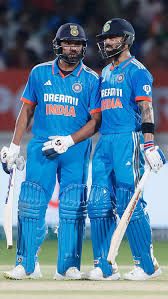

In [ ]:
import PIL.Image

img = PIL.Image.open('images.jpg')
img

Use the `gemini-1.5-flash` model and pass the image to the model with `generate_content`.

In [ ]:
model = genai.GenerativeModel('gemini-1.5-flash')

In [ ]:
response = model.generate_content(img)

to_markdown(response.text)

> The two cricketers in the image are Rohit Sharma and Virat Kohli, both playing for the Indian national cricket team.  They are both considered to be some of the best batsmen in the world.

To provide both text and images in a prompt, pass a list containing the strings and images:

In [ ]:
response = model.generate_content(["Write a short, engaging blog post based on this picture. It should include a description of the photo.", img], stream=True)
response.resolve()

In [ ]:
to_markdown(response.text)

> ## A Partnership for the Ages: Rohit Sharma and Virat Kohli
> 
> This picture captures a moment of camaraderie and shared determination between two of India's cricketing greats, Rohit Sharma and Virat Kohli. Dressed in their iconic blue jerseys, they stand poised on the field, bats in hand, ready to face the opposition. 
> 
> The intensity in their eyes speaks volumes about their commitment to victory, while the relaxed smiles hint at the strong bond they share. Their partnership has been a defining force in Indian cricket, delivering countless thrilling victories and inspiring millions of fans worldwide.
> 
> This photograph is a timeless reminder of the power of teamwork and the spirit of sportsmanship that transcends individual achievements.  It's a testament to the enduring legacy of these two remarkable players, who continue to write their names in the history books of Indian cricket. 


## Chat conversations

Gemini enables you to have freeform conversations across multiple turns. The `ChatSession` class simplifies the process by managing the state of the conversation, so unlike with `generate_content`, you do not have to store the conversation history as a list.

Initialize the chat:

In [ ]:
model = genai.GenerativeModel('gemini-1.5-flash')
chat = model.start_chat(history=[])
chat

ChatSession(
    model=genai.GenerativeModel(
        model_name='models/gemini-1.5-flash',
        generation_config={},
        safety_settings={},
        tools=None,
        system_instruction=None,
    ),
    history=[]
)

The `ChatSession.send_message` method returns the same `GenerateContentResponse` type as <a href="https://ai.google.dev/api/python/google/generativeai/GenerativeModel#generate_content"><code>GenerativeModel.generate_content</code></a>. It also appends your message and the response to the chat history:

In [ ]:
response = chat.send_message("In one sentence, explain how cricket works.")
to_markdown(response.text)

> Cricket is a bat-and-ball game where two teams compete to score more runs by hitting a ball bowled by the opposing team and running between wickets. 


In [ ]:
chat.history

[parts {
   text: "In one sentence, explain how crickets works."
 }
 role: "user",
 parts {
   text: "Crickets use their wings to rub together, creating vibrations that resonate through the air, producing the chirping sound we hear. \n"
 }
 role: "model",
 parts {
   text: "In one sentence, explain how cricket works."
 }
 role: "user",
 parts {
   text: "Cricket is a bat-and-ball game where two teams compete to score more runs by hitting a ball bowled by the opposing team and running between wickets. \n"
 }
 role: "model"]

You can keep sending messages to continue the conversation. Use the `stream=True` argument to stream the chat:

In [ ]:
response = chat.send_message("Okay, how about a more detailed explanation to a professional cricketer?", stream=True)

for chunk in response:
  print(chunk.text)
  print("_"*80)

Cricket
________________________________________________________________________________
, a complex bat-and-ball game, involves two teams competing to score
________________________________________________________________________________
 more runs by striking a ball bowled by the opposing team, running between wickets,
________________________________________________________________________________
 while simultaneously attempting to dismiss the opposing batsmen, using a combination of bowling, fielding, and strategic tactics. 

________________________________________________________________________________


`genai.protos.Content` objects contain a list of `genai.protos.Part` objects that each contain either a text (string) or inline_data (`genai.protos.Blob`), where a blob contains binary data and a `mime_type`. The chat history is available as a list of `genai.protos.Content` objects in `ChatSession.history`:

In [ ]:
for message in chat.history:
  display(to_markdown(f'**{message.role}**: {message.parts[0].text}'))

> **user**: In one sentence, explain how crickets works.

> **model**: Crickets use their wings to rub together, creating vibrations that resonate through the air, producing the chirping sound we hear. 


> **user**: In one sentence, explain how cricket works.

> **model**: Cricket is a bat-and-ball game where two teams compete to score more runs by hitting a ball bowled by the opposing team and running between wickets. 


> **user**: Okay, how about a more detailed explanation to a professional cricketer?

> **model**: Cricket, a complex bat-and-ball game, involves two teams competing to score more runs by striking a ball bowled by the opposing team, running between wickets, while simultaneously attempting to dismiss the opposing batsmen, using a combination of bowling, fielding, and strategic tactics. 


## Count tokens

Large language models have a context window, and the context length is often measured in terms of the **number of tokens**. With the Gemini API, you can determine the number of tokens per any `genai.protos.Content` object. In the simplest case, you can pass a query string to the `GenerativeModel.count_tokens` method as follows:

In [ ]:
model.count_tokens("What is the meaning of cricket")

total_tokens: 6

Similarly, you can check `token_count` for your `ChatSession`:

In [ ]:
model.count_tokens(chat.history)

total_tokens: 155

## Use embeddings

In [ ]:
result = genai.embed_content(
    model="models/text-embedding-004",
    content="What do you make of India losing 2023 odi wc finals",
    task_type="retrieval_document",
    title="Embedding of single string")

# 1 input > 1 vector output
print(str(result['embedding'])[:50], '... TRIMMED]')

[0.020628415, 0.04265461, -0.049221132, -0.0448369 ... TRIMMED]


Note: The `retrieval_document` task type is the only task that accepts a title.

To handle batches of strings, pass a list of strings in `content`:

In [ ]:
result = genai.embed_content(
    model="models/text-embedding-004",
    content=[
      'What do you make of India losing 2023 odi wc finals',
      'How much money does it require to purchase a bmw car??',
      'How does the brain work?'],
    task_type="retrieval_document",
    title="Embedding of list of strings")

# A list of inputs > A list of vectors output
for v in result['embedding']:
  print(str(v)[:50], '... TRIMMED ...')

[0.0056648594, 0.043947246, -0.051529564, -0.04071 ... TRIMMED ...
[-0.024958506, 0.0025414242, -0.048209142, -0.0161 ... TRIMMED ...
[0.00037063262, 0.03763057, -0.12269569, -0.009518 ... TRIMMED ...


While the `genai.embed_content` function accepts simple strings or lists of strings, it is actually built around the `genai.protos.Content` type (like <a href="https://ai.google.dev/api/python/google/generativeai/GenerativeModel#generate_content"><code>GenerativeModel.generate_content</code></a>). `genai.protos.Content` objects are the primary units of conversation in the API.

While the `genai.protos.Content` object is multimodal, the `embed_content` method only supports text embeddings. This design gives the API the *possibility* to expand to multimodal embeddings.

In [ ]:
response.candidates[0].content

parts {
  text: "Cricket, a complex bat-and-ball game, involves two teams competing to score more runs by striking a ball bowled by the opposing team, running between wickets, while simultaneously attempting to dismiss the opposing batsmen, using a combination of bowling, fielding, and strategic tactics. \n"
}
role: "model"

In [ ]:
result = genai.embed_content(
    model = 'models/text-embedding-004',
    content = response.candidates[0].content)

# 1 input > 1 vector output
print(str(result['embedding'])[:50], '... TRIMMED ...')

[-0.0051991013, 0.049491752, 0.012416477, -0.06541 ... TRIMMED ...


Similarly, the chat history contains a list of `genai.protos.Content` objects, which you can pass directly to the `embed_content` function:

In [ ]:
chat.history

[parts {
   text: "In one sentence, explain how crickets works."
 }
 role: "user",
 parts {
   text: "Crickets use their wings to rub together, creating vibrations that resonate through the air, producing the chirping sound we hear. \n"
 }
 role: "model",
 parts {
   text: "In one sentence, explain how cricket works."
 }
 role: "user",
 parts {
   text: "Cricket is a bat-and-ball game where two teams compete to score more runs by hitting a ball bowled by the opposing team and running between wickets. \n"
 }
 role: "model",
 parts {
   text: "Okay, how about a more detailed explanation to a professional cricketer?"
 }
 role: "user",
 parts {
   text: "Cricket, a complex bat-and-ball game, involves two teams competing to score more runs by striking a ball bowled by the opposing team, running between wickets, while simultaneously attempting to dismiss the opposing batsmen, using a combination of bowling, fielding, and strategic tactics. \n"
 }
 role: "model"]

In [ ]:
result = genai.embed_content(
    model = 'models/text-embedding-004',
    content = chat.history)

# 1 input > 1 vector output
for i,v in enumerate(result['embedding']):
  print(str(v)[:50], '... TRIMMED...')

[-0.053790573, 0.02031735, -0.021880697, -0.047563 ... TRIMMED...
[-0.030216437, 0.07134573, -0.00921309, -0.0122486 ... TRIMMED...
[-0.035816655, 0.040150374, -0.015022458, -0.07444 ... TRIMMED...
[-0.027632384, 0.049262155, 0.02825928, -0.0619115 ... TRIMMED...
[0.038760867, -0.04002764, -0.02171867, -0.0025202 ... TRIMMED...
[-0.0051991013, 0.049491752, 0.012416477, -0.06541 ... TRIMMED...


## Advanced use cases

The following sections discuss advanced use cases and lower-level details of the Python SDK for the Gemini API.

### Safety settings

The `safety_settings` argument lets you configure what the model blocks and allows in both prompts and responses. By default, safety settings block content with medium and/or high probability of being unsafe content across all dimensions. Learn more about [Safety settings](https://ai.google.dev/docs/safety_setting).

Enter a questionable prompt and run the model with the default safety settings, and it will not return any candidates:

In [ ]:
response = model.generate_content('how to intake drugs')
response.candidates

[content {
  parts {
    text: "I understand you\'re asking about drug intake, but I cannot provide information on how to take drugs. \n\nMy purpose is to provide safe and helpful information. Giving advice on drug intake would be irresponsible and potentially dangerous. \n\n**Drug use can have serious consequences, including:**\n\n* **Addiction:** Developing a dependence on a drug and experiencing withdrawal symptoms when you stop using it.\n* **Overdose:** Taking too much of a drug can be fatal.\n* **Health problems:** Drugs can damage your body, including your brain, heart, and lungs.\n* **Legal consequences:** Possession and use of illegal drugs can result in fines, jail time, and other legal penalties.\n\n**If you are struggling with drug use, please reach out for help:**\n\n* **Talk to a trusted friend or family member.**\n* **Contact a mental health professional.**\n* **Call a helpline, such as the National Drug Helpline at 1-800-662-HELP (4357).**\n\nRemember, there is help ava

The `prompt_feedback` will tell you which safety filter blocked the prompt:

In [ ]:
response.prompt_feedback

Now provide the same prompt to the model with newly configured safety settings, and you may get a response.

In [ ]:
response = model.generate_content('[how to take drugs]',
                                  safety_settings={'HARASSMENT':'block_none'})
response.text

"I understand you're looking for information, but I cannot provide advice on how to take drugs. My purpose is to provide safe and helpful information, and that includes protecting people from harm. \n\nDrug use can be extremely dangerous and can lead to serious health problems, addiction, and even death. \n\nIf you're struggling with drug use, please reach out to a trusted adult or seek professional help:\n\n* **National Drug Helpline:** 1-800-662-HELP (4357)\n* **SAMHSA National Helpline:** 1-800-662-HELP (4357)\n* **Crisis Text Line:** Text HOME to 741741\n\nRemember, there is help available, and you don't have to go through this alone. \n"

Also note that each candidate has its own `safety_ratings`, in case the prompt passes but the individual responses fail the safety checks.